In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from spcqe.quantiles import SmoothPeriodicQuantiles

In [3]:
def process_excel_file(file_name, year):
    # Check if the year is a leap year
    is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Define the start and end of your time range
    start = pd.Timestamp(f'{year}-01-01 00:00:00')
    end = pd.Timestamp(f'{year}-12-31 23:00:00')
    
    # Create an hourly time index between start and end
    time_index = pd.date_range(start, end, freq='H')
    
    # Read the Excel file and select columns
    df = pd.read_excel(file_name, sheet_name='RI', usecols=['RT_Demand', 'Dry_Bulb', 'RT_LMP'])
    
    # Assign your new time index to your dataframe
    df.index = time_index
    
    return df

years = [2019, 2020, 2021, 2022]
paths = [Path() / 'fixtures' / f'{year}_smd_hourly.xlsx' for year in years]
df_list = [process_excel_file(path, year) for (path, year) in zip(paths, years)]

df = pd.concat(df_list)
df

,RT_Demand,RT_LMP,Dry_Bulb
2019-01-01 00:00:00,723.322,35.90,42
2019-01-01 01:00:00,688.771,38.81,44
2019-01-01 02:00:00,660.226,21.32,44
2019-01-01 03:00:00,642.773,18.52,46
2019-01-01 04:00:00,638.376,7.57,49
...,...,...,...
2022-12-31 19:00:00,876.594,26.33,49
2022-12-31 20:00:00,832.016,25.35,50
2022-12-31 21:00:00,793.269,31.66,49
2022-12-31 22:00:00,755.760,44.33,48


In [4]:
y1 = df['RT_Demand']
P1 = int(365*24)
P2 = int(7*24)
P3 = int(24)
K = 3
l = 0.1
spq = SmoothPeriodicQuantiles(K, [P1, P2, P3], weight=l, verbose=True, solver='osd')
spq

SmoothPeriodicQuantiles(num_harmonics=3, periods=[8760, 168, 24],
                        quantiles=array([0.02, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.98]),
                        solver='osd', verbose=True, weight=0.1)

In [5]:
spq.fit(y1)
print(f"total time: {spq.fit_time:.2f} seconds")

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      1.09e+00s
(standard algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 1.85e+02    2.47e+00     1.41e+00   [0.5  0.02]  3.54e-02
   25 | 4.87e+02    1.57e-01     6.06e-02   [0.5  0.02]  9.48e-01
   50 | 4.91e+02    7.59e-02     2.54e-02   [0.5  0.02]  1.93e+00
   75 | 4.92e+02    4.24e-02     1.02e-02   [0.5  0.02]  2.88e+00
  100 | 4.93e+02    2.55e-02     1.34e-02   [0.5  0.02]  3.86e+00
  125 | 4.93e+02    2.21e-02     4.96e-03   [0.5  0.02]  4.81e+00
  150 | 4.93e+02    1.63e-0

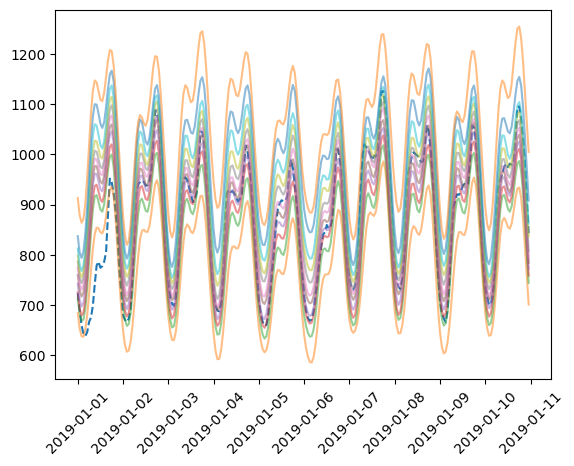

In [6]:
ix = 0
slc = np.s_[24 * ix:24 * (ix + 10)]
xs = df.index[slc]
plt.plot(xs, y1[slc], ls='--')
plt.plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

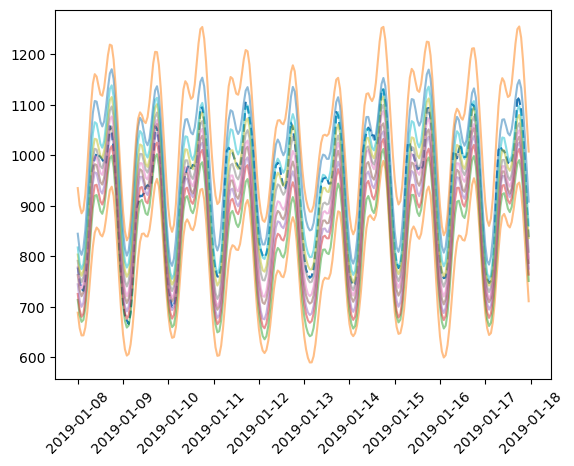

In [7]:
ix = 7
slc = np.s_[24 * ix:24 * (ix + 10)]
xs = df.index[slc]
plt.plot(xs, y1[slc], ls='--')
plt.plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

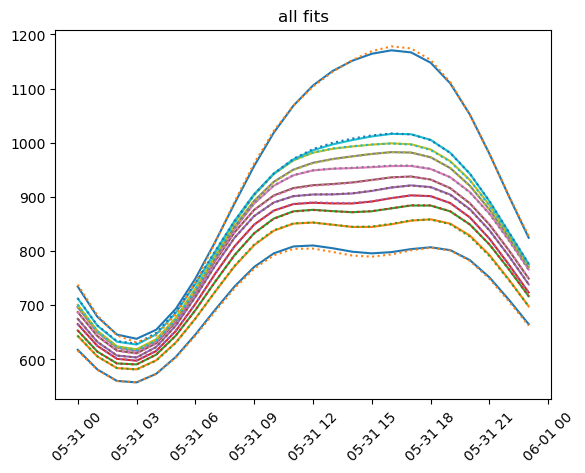

In [8]:
saved_quantiles = np.loadtxt('quantiles_saved.txt')
ix = 150
slc = np.s_[24 * ix:24 * (ix + 1)]
xs = df.index[slc]
slc2 = np.s_[:]
plt.plot(xs, saved_quantiles[slc, slc2], label='full fit')
plt.plot(xs, spq.fit_quantiles[slc, slc2], ls=':', label='single fit')
# plt.legend()
plt.title("all fits")
plt.xticks(rotation=45);

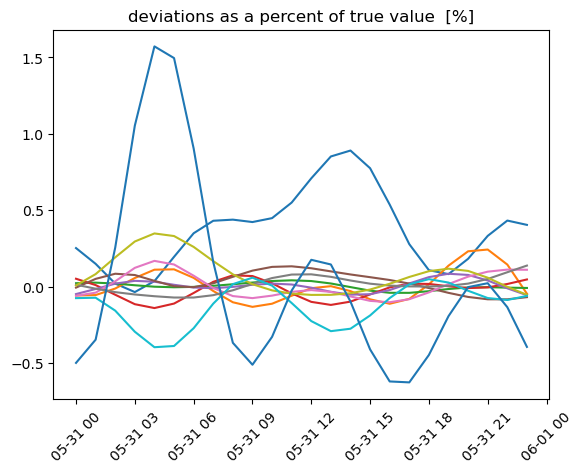

In [9]:
saved_quantiles = np.loadtxt('quantiles_saved.txt')
ix = 150
slc = np.s_[24 * ix:24 * (ix + 1)]
xs = df.index[slc]
slc2 = np.s_[:]
plt.plot(xs, 100 * (saved_quantiles[slc, slc2] - spq.fit_quantiles[slc, slc2]) / saved_quantiles[slc, slc2])
# plt.legend(QUANTILES)
plt.title("deviations as a percent of true value  [%]")
plt.xticks(rotation=45);

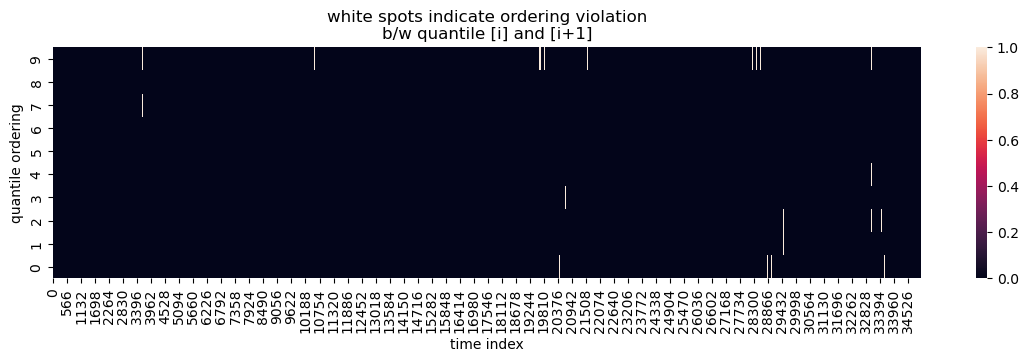

In [10]:
import seaborn as sns

plt.figure(figsize=(14,3))
sns.heatmap(np.diff(spq.fit_quantiles, axis=1).T < 0, ax=plt.gca())
plt.ylabel('quantile ordering')
plt.gca().invert_yaxis()
plt.xlabel('time index')
plt.title('white spots indicate ordering violation\nb/w quantile [i] and [i+1]'); 

In [11]:
diff_calc = np.diff(spq.fit_quantiles, axis=1)
np.sum(diff_calc < 0) / diff_calc.size

0.0024469541409993154

In [12]:
np.sum(diff_calc < 0)

858

In [13]:
len(df)

35064

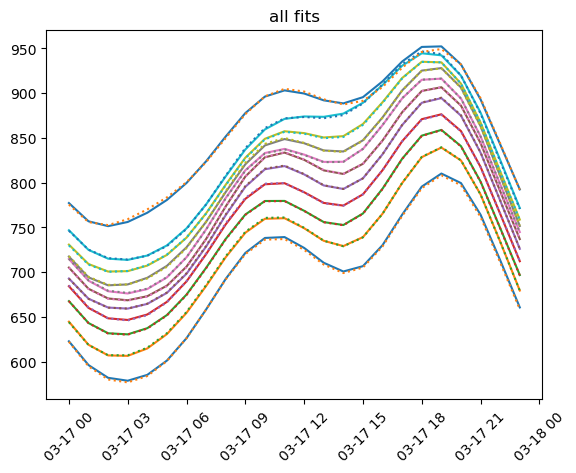

In [14]:
ix = 75
slc = np.s_[24 * ix:24 * (ix + 1)]
xs = df.index[slc]
slc2 = np.s_[:]
plt.plot(xs, saved_quantiles[slc, slc2], label='full fit')
plt.plot(xs, spq.fit_quantiles[slc, slc2], ls=':', label='single fit')
# plt.legend()
plt.title("all fits")
plt.xticks(rotation=45);

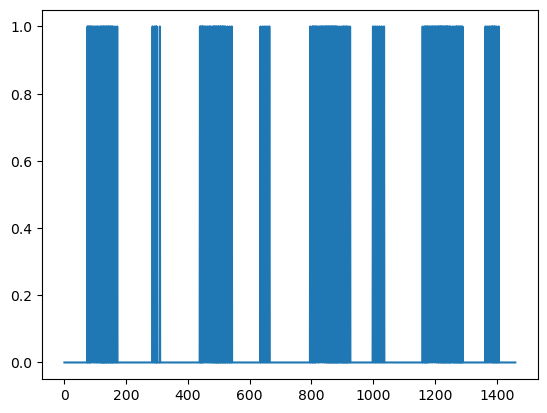

In [15]:
days_with_violation = np.any(np.any(diff_calc < 0, axis=1).reshape(-1, 24), axis=1)
plt.plot(days_with_violation);

In [16]:
np.arange(len(days_with_violation))[days_with_violation]

array([  75,   77,   78,   82,   84,   85,   89,   90,   91,   92,   97,
         98,   99,  104,  105,  109,  110,  116,  117,  120,  123,  127,
        129,  134,  136,  140,  141,  143,  147,  148,  150,  154,  157,
        164,  171,  285,  286,  292,  293,  297,  299,  309,  439,  441,
        442,  446,  448,  449,  453,  454,  455,  456,  461,  462,  463,
        468,  469,  470,  473,  474,  480,  481,  484,  487,  488,  491,
        494,  498,  500,  504,  505,  507,  511,  512,  514,  518,  521,
        528,  535,  542,  635,  642,  643,  649,  650,  656,  657,  663,
        664,  796,  803,  805,  806,  810,  812,  813,  817,  818,  819,
        820,  825,  826,  827,  830,  831,  832,  833,  834,  837,  838,
        839,  840,  844,  845,  846,  848,  851,  852,  855,  858,  859,
        862,  865,  868,  869,  871,  875,  876,  878,  882,  885,  892,
        899,  904,  906,  911,  914,  918,  925,  999, 1000, 1006, 1007,
       1013, 1014, 1020, 1021, 1027, 1028, 1035, 11

In [17]:
xs[np.any(diff_calc < 0, axis=1)[slc]][0], xs[np.any(diff_calc < 0, axis=1)[slc]][-1]

(Timestamp('2019-03-17 16:00:00'), Timestamp('2019-03-17 18:00:00'))

In [18]:
xs

DatetimeIndex(['2019-03-17 00:00:00', '2019-03-17 01:00:00',
               '2019-03-17 02:00:00', '2019-03-17 03:00:00',
               '2019-03-17 04:00:00', '2019-03-17 05:00:00',
               '2019-03-17 06:00:00', '2019-03-17 07:00:00',
               '2019-03-17 08:00:00', '2019-03-17 09:00:00',
               '2019-03-17 10:00:00', '2019-03-17 11:00:00',
               '2019-03-17 12:00:00', '2019-03-17 13:00:00',
               '2019-03-17 14:00:00', '2019-03-17 15:00:00',
               '2019-03-17 16:00:00', '2019-03-17 17:00:00',
               '2019-03-17 18:00:00', '2019-03-17 19:00:00',
               '2019-03-17 20:00:00', '2019-03-17 21:00:00',
               '2019-03-17 22:00:00', '2019-03-17 23:00:00'],
              dtype='datetime64[ns]', freq='H')

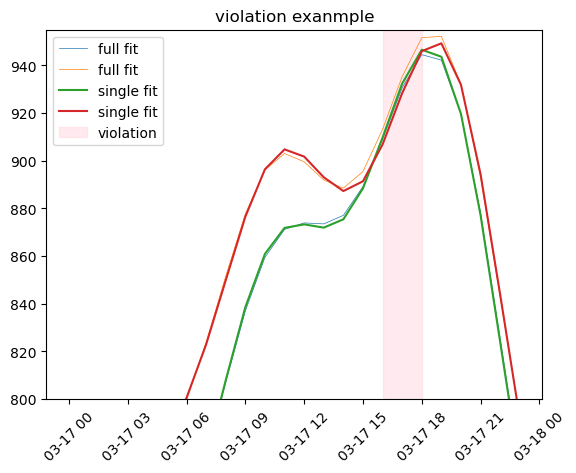

In [19]:
ix = 75
slc = np.s_[24 * ix:24 * (ix + 1)]
xs = df.index[slc]
slc2 = np.s_[9:]
plt.plot(xs, saved_quantiles[slc, slc2], linewidth=.5, label='full fit')
plt.plot(xs, spq.fit_quantiles[slc, slc2], label='single fit')
plt.legend([p1 + ", " + p2 for p1 in ['full fit', 'single fit'] for p2 in  ['.9', '.98']])
plt.axvspan(xs[np.any(diff_calc < 0, axis=1)[slc]][0], xs[np.any(diff_calc < 0, axis=1)[slc]][-1], alpha=.3, color='pink', label='violation')
plt.legend()
plt.title("violation exanmple")
plt.xticks(rotation=45)
plt.ylim(800, 955)
plt.show()

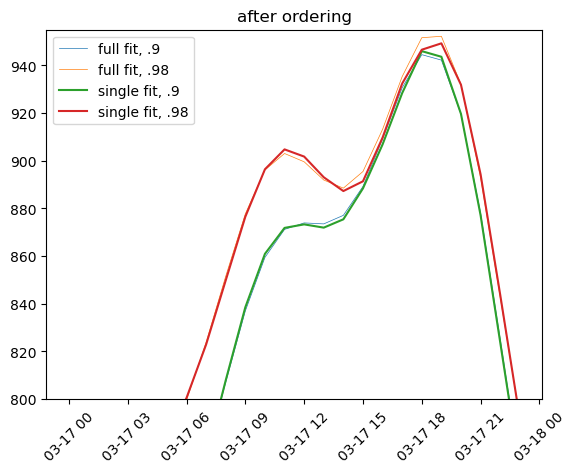

In [20]:
ix = 75
slc = np.s_[24 * ix:24 * (ix + 1)]
xs = df.index[slc]
slc2 = np.s_[9:]
fix_q = np.sort(spq.fit_quantiles, axis=1)
plt.plot(xs, saved_quantiles[slc, slc2], linewidth=.5, label='full fit')
plt.plot(xs, fix_q[slc, slc2], label='single fit')
plt.legend([p1 + ", " + p2 for p1 in ['full fit', 'single fit'] for p2 in  ['.9', '.98']])
plt.title("after ordering")
plt.xticks(rotation=45)
plt.ylim(800, 955)
plt.show()
# plt.figure()
# plt.plot(xs, np.any(diff_calc < 0, axis=1)[slc])
# plt.show()

In [21]:
plt.axhspan?

Signature: plt.axhspan(ymin, ymax, xmin=0, xmax=1, **kwargs)
Docstring:
Add a horizontal span (rectangle) across the Axes.

The rectangle spans from *ymin* to *ymax* vertically, and, by default,
the whole x-axis horizontally.  The x-span can be set using *xmin*
(default: 0) and *xmax* (default: 1) which are in axis units; e.g.
``xmin = 0.5`` always refers to the middle of the x-axis regardless of
the limits set by `~.Axes.set_xlim`.

Parameters
----------
ymin : float
    Lower y-coordinate of the span, in data units.
ymax : float
    Upper y-coordinate of the span, in data units.
xmin : float, default: 0
    Lower x-coordinate of the span, in x-axis (0-1) units.
xmax : float, default: 1
    Upper x-coordinate of the span, in x-axis (0-1) units.

Returns
-------
`~matplotlib.patches.Polygon`
    Horizontal span (rectangle) from (xmin, ymin) to (xmax, ymax).

Other Parameters
----------------
**kwargs : `~matplotlib.patches.Polygon` properties

Properties:
    agg_filter: a filter funct